# tfData Demo
Reference
* https://www.machinelearningmindset.com/tfrecords-for-tensorflow/
* https://androidkt.com/feed-tfrecord-to-keras/


In [1]:
import tensorflow as tf 
import os 
import numpy as np 

from PIL import Image

from tensorflow.keras.layers import *
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
working_dir = '/Users/rick/Desktop/tfRecordDemo'
data_dir = os.path.join(working_dir,'data')

print("working_dir: {}".format(working_dir))
print("data_dir: {}".format(data_dir))
print("folders in data_dir: {}".format(os.listdir(data_dir)))

working_dir: /Users/rick/Desktop/tfRecordDemo
data_dir: /Users/rick/Desktop/tfRecordDemo/data
folders in data_dir: ['.DS_Store', 'img1', 'img3', 'img2', 'demo_record.tfrecords']


## 1. First convert data to binary format with tfRecord

In this example, the input values for our model will be images from the three 
folders: img1, img2, img3 from data_dir. Suppose our model had three inputs where images from each
folder corresponded to an input. Then, as a target, lets say it was a dense layer for regression
that had three nodes. This model is completly hypthotetical but it allows this example to be insightful
due to haveing multiple inputs, inputs being images with dtypes of int, and the targets being floats. 


In [3]:
# Inside each folder (img1, img2, and img3) are ten photos
# There is no "actual" target values for this task, thus random values will be made instead
# This data set is as follow: 10 samples, (X[img1,img2,img3],Y[target])

img1_names = os.listdir(data_dir+"/img1")
img2_names = os.listdir(data_dir+"/img2")
img3_names = os.listdir(data_dir+"/img3")

img1_paths = [os.path.join(data_dir+"/img1",name) for i,name in enumerate(img1_names)]
img2_paths = [os.path.join(data_dir+"/img2",name) for i,name in enumerate(img2_names)]
img3_paths = [os.path.join(data_dir+"/img3",name) for i,name in enumerate(img3_names)]

print("/img1 file names: {}".format(img1_names))
print()

print("/img2 file names: {}".format(img2_names))
print()

print("/img3 file names: {}".format(img3_names))
print()


/img1 file names: ['2020_01_23_01_30.jpg', '2020_01_23_01_45.jpg', '2020_01_23_02_00.jpg', '2020_01_23_02_15.jpg', '2020_01_23_02_30.jpg', '2020_01_23_03_00.jpg', '2020_01_23_00_45.jpg', '2020_01_23_01_15.jpg', '2020_01_23_02_45.jpg', '2020_01_23_01_00.jpg']

/img2 file names: ['2020_01_23_01_30.jpg', '2020_01_23_01_45.jpg', '2020_01_23_02_00.jpg', '2020_01_23_02_15.jpg', '2020_01_23_02_30.jpg', '2020_01_23_03_00.jpg', '2020_01_23_00_45.jpg', '2020_01_23_01_15.jpg', '2020_01_23_02_45.jpg', '2020_01_23_01_00.jpg']

/img3 file names: ['2020_01_23_01_30.jpg', '2020_01_23_01_45.jpg', '2020_01_23_02_00.jpg', '2020_01_23_02_15.jpg', '2020_01_23_02_30.jpg', '2020_01_23_03_00.jpg', '2020_01_23_00_45.jpg', '2020_01_23_01_15.jpg', '2020_01_23_02_45.jpg', '2020_01_23_01_00.jpg']



In [4]:
# function to open image and then make into tfRecord type 
# Data can be converted by tf.train.feature with to 
#     three types:  tf.train.BytesList, tf.train.FloatList, tf.train.Int64List

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def make_img_tfRecord(path1,path2,path3,img_shape):
    img1 = Image.open(path1)
    img1 = img1.resize((img_shape[0],img_shape[1]))
    img1 = np.array(img1) # dtype is float64
    
    img2 = Image.open(path2)
    img2 = img2.resize((img_shape[0],img_shape[1]))
    img2 = np.array(img2) # dtype is float64
    
    img3 = Image.open(path3)
    img3 = img3.resize((img_shape[0],img_shape[1])) 
    img3 = np.array(img3) # dtype is float64

    # some random float vector to be the target value 
    y = np.random.uniform(0,1,(3,1))
        
    feature = {
        'dim_1': _int64_feature(img_shape[1]),
        'dim_2': _int64_feature(img_shape[0]),
        'dim_3': _int64_feature(img_shape[2]),
        'label': _bytes_feature(y.tobytes()),
        'image_raw_1': _bytes_feature(img1.tobytes()),
        'image_raw_2': _bytes_feature(img2.tobytes()),
        'image_raw_3': _bytes_feature(img3.tobytes()),
        }

        
    return tf.train.Example(features=tf.train.Features(feature=feature))
        

In [5]:
img_shape = (640,480,3)

record_file = os.path.join(data_dir,'demo_record.tfrecords')
with tf.io.TFRecordWriter(record_file) as writer:
    for i in range(len(img1_paths)):
        paths = [img1_paths[i],img2_paths[i],img3_paths[i]]
        tf_example = make_img_tfRecord(paths[0],paths[1],paths[2],img_shape)
        writer.write(tf_example.SerializeToString())

## 2. Declare tf.Data object

In [6]:
# Create the dataset object from tfrecord file(s)
dataset = tf.data.TFRecordDataset(record_file, buffer_size=100)

In [7]:
# Decoding function
def parse_record(record):
    name_to_features = {
        'dim_1': tf.io.FixedLenFeature([], tf.int64),
        'dim_2': tf.io.FixedLenFeature([], tf.int64),
        'dim_3': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string),
        'image_raw_1': tf.io.FixedLenFeature([], tf.string),
        'image_raw_2': tf.io.FixedLenFeature([], tf.string),
        'image_raw_3': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

def decode_record(record):
    img1 = tf.io.decode_raw(
        record['image_raw_1'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
    img2 = tf.io.decode_raw(
        record['image_raw_2'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
    img3 = tf.io.decode_raw(
        record['image_raw_3'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
    
    label = tf.io.decode_raw(
        record['label'], out_type='float64', little_endian=True, fixed_length=None, name=None
    )
    
    dim1 = record['dim_1']
    dim2 = record['dim_2']
    dim3 = record['dim_3']

    img1 = tf.reshape(img1, (dim1, dim2,dim3))
    img2 = tf.reshape(img2, (dim1, dim2,dim3))
    img3 = tf.reshape(img3, (dim1, dim2,dim3))
    
    return (img1,img2,img3, label)

In [8]:
img1_list, img2_list, img3_list, labels = [], [], [], []
for record in dataset:
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)
    img1,img2,img3,label = decoded_record
    
    img1_list.append(img1)
    img2_list.append(img2)
    img3_list.append(img3)
    labels.append(label)

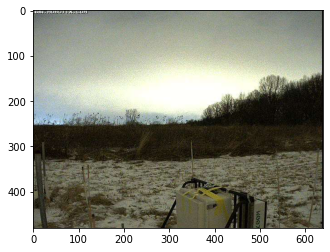

In [9]:
img = img1_list[0].numpy()
img = Image.fromarray(img,'RGB')
imgplot = plt.imshow(img)
plt.show()

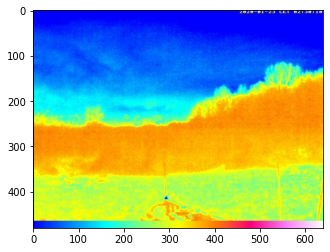

In [10]:
img = img2_list[0].numpy()
img = Image.fromarray(img,'RGB')
imgplot = plt.imshow(img)
plt.show()

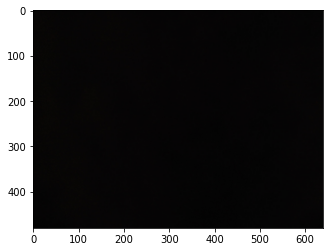

In [11]:
img = img3_list[0].numpy()
img = Image.fromarray(img,'RGB')
imgplot = plt.imshow(img)
plt.show()

In [12]:
print("Target values for sample: {}".format(labels[0].numpy()))

Target values for sample: [0.08364908 0.09722638 0.18836349]


## 3. Train model with tf.Data

In [13]:
def get_compiled_model() -> tf.keras.Model:
    # shape=(batch_size,channels, row, col)
    input_1 = Input(shape=(480, 640,3),name="input_1")
    x1 = SeparableConv2D(8,(4, 4), padding="same",data_format='channels_last')(input_1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    input_2= Input(shape=(480, 640,3),name="input_2")
    x2 = SeparableConv2D(8,(4, 4), padding="same",data_format='channels_last')(input_2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)

    input_3 = Input(shape=(480, 640,3),name="input_3")
    x3 = SeparableConv2D(8,(4, 4), padding="same",data_format='channels_last')(input_3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)

    x_concat = Concatenate(axis=-1)([x1, x2, x3])
    x_flat = GlobalAveragePooling2D()(x_concat)
    yh = Dense(3, activation="softmax")(x_flat)

    model = Model(inputs = [input_1, input_2, input_3],outputs=yh)

    model.compile(loss="mean_absolute_error", optimizer=RMSprop(lr=0.002), metrics=["acc"])

    return model

In [14]:
model = get_compiled_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 480, 640, 8)  80          input_1[0][0]                    
______________________________________________________________________________________________

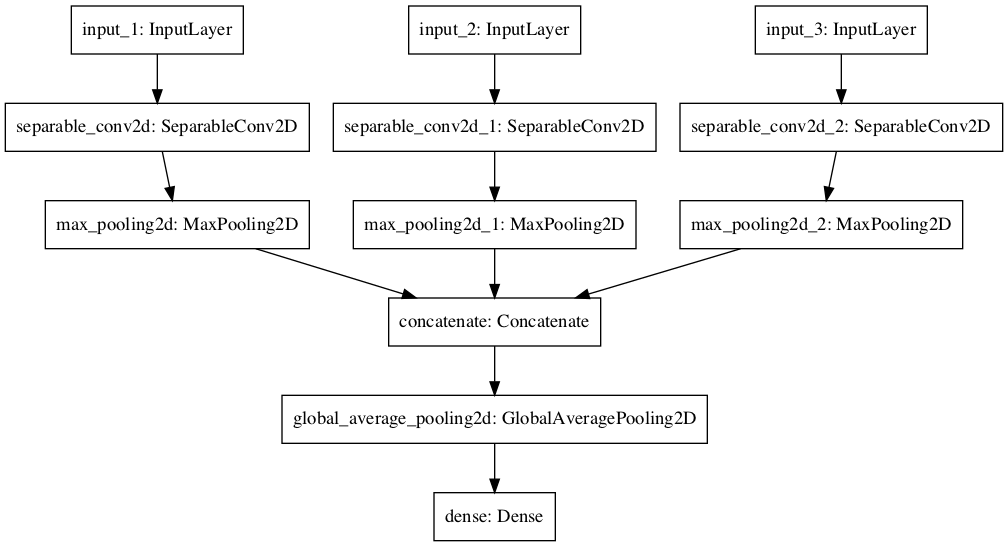

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
AUTO = tf.data.experimental.AUTOTUNE 

def read_tf_image_and_label(record):    
    parsed_record = parse_record(record)
    img1,img2,img3,label = decode_record(parsed_record)
    img1 = tf.cast(img1, tf.float32) / 255.0
    img2 = tf.cast(img2, tf.float32) / 255.0
    img3 = tf.cast(img3, tf.float32) / 255.0
    return {'input_1': img1,'input_2': img2,'input_3': img3}, label

def get_training_dataset(record_files):
    dataset = tf.data.TFRecordDataset(record_files, buffer_size=100)
    dataset = dataset.map(read_tf_image_and_label, num_parallel_calls=AUTO)
    dataset = dataset.batch(2) 
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [17]:
record_files = os.path.join(data_dir,'demo_record.tfrecords')
history = model.fit(get_training_dataset(record_files),epochs=10,verbose=1)


Epoch 1/10
5/5 [==============================] - 1s 287ms/step - loss: 0.2700 - acc: 0.2000
Epoch 2/10
5/5 [==============================] - 2s 315ms/step - loss: 0.2540 - acc: 0.2000
Epoch 3/10
5/5 [==============================] - 1s 273ms/step - loss: 0.2505 - acc: 0.2000
Epoch 4/10
5/5 [==============================] - 2s 326ms/step - loss: 0.2500 - acc: 0.2000
Epoch 5/10
5/5 [==============================] - 2s 309ms/step - loss: 0.2500 - acc: 0.2000
Epoch 6/10
5/5 [==============================] - 2s 322ms/step - loss: 0.2500 - acc: 0.2000
Epoch 7/10
5/5 [==============================] - 1s 299ms/step - loss: 0.2500 - acc: 0.2000
Epoch 8/10
5/5 [==============================] - 2s 303ms/step - loss: 0.2488 - acc: 0.2000
Epoch 9/10
5/5 [==============================] - 1s 296ms/step - loss: 0.2500 - acc: 0.2000
Epoch 10/10
5/5 [==============================] - 2s 304ms/step - loss: 0.2500 - acc: 0.2000
